## Stackoverflow Tag Predictor

Click here for [EDA](#EDA)

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

# Stack Overflow: Tag Prediction

<h2> 1.3 Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

<h1>2. Machine Learning problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />


__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

<h2>2.2 Mapping the real-world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3>2.2.2 Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading and Cleaning </h2>

<h3>3.1.1 Using Pandas with SQLite to Load the data</h3>

In [2]:
#Creating db file from csv
#Learn SQL: https://www.w3schools.com/sql/default.asp
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

<h3> 3.1.2 Counting the number of rows </h3>

In [3]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:03:07.959307


<h3>3.1.3 Checking for duplicates </h3>

In [6]:
#Learn SQl: https://www.w3schools.com/sql/default.asp
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:02:48.980611


In [5]:
df_no_dup.head()
# we can observe that there are duplicates

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [6]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 1827881 ( 30.292038906260256 % )


In [7]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [8]:
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [7]:
words = []
for i in range(len(df_no_dup['Tags'])):
    words.append(df_no_dup['Tags'][i])

In [8]:
for i in range(len(df_no_dup['Tags'])):
    try:
        split = words[i]
    except:
        print('index', i)

def splitter(x):
    try:
        split = list(x.split(" "))
        return len(split)
    except:
        return 0

In [10]:
lengths = []
for i in df_no_dup['Tags']:
    lengths.append(splitter(i))

In [11]:
len(lengths)

4206315

In [12]:
len(lengths)

4206315

In [13]:
start = datetime.now()
df_no_dup["tag_count"] = lengths
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:01.151796


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


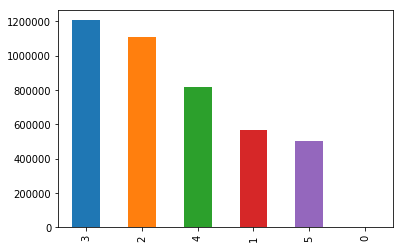

In [12]:
# distribution of number of tags per question
df_no_dup.tag_count.value_counts().plot(kind='bar')

In [ ]:
df

In [13]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [14]:
con = sqlite3.connect('train_no_dup.db')
tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)

In [19]:
tag_data.head()

,Tags
0,c++ c
1,c# silverlight data-binding
2,c# silverlight data-binding columns
3,jsp jstl
4,java jdbc


In [15]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:00:06.873090


In [16]:
tag_data.head()

,Tags
1,c# silverlight data-binding
2,c# silverlight data-binding columns
3,jsp jstl
4,java jdbc
5,facebook api facebook-php-sdk


<h2> 3.2 Analysis of Tags </h2>

<h3> 3.2.1 Total number of unique tags </h3>

In [16]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer( tokenizer = lambda x: x.split() )
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'].values.astype('U'))

In [18]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206314
Number of unique tags : 42049


In [18]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


<h3> 3.2.3 Number of times a tag appeared </h3>

In [19]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [30]:
tags[:10]

['.a',
 '.app',
 '.asp.net-mvc',
 '.aspxauth',
 '.bash-profile',
 '.class-file',
 '.cs-file',
 '.doc',
 '.drv',
 '.ds-store']

In [25]:
freqs

array([18, 37,  1, ...,  8, 32,  1], dtype=int64)

In [31]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [32]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

In [33]:
tag_df_sorted.head()

,Tags,Counts
4337,c#,331505
18069,java,299414
27249,php,284103
18157,javascript,265423
1234,android,235436


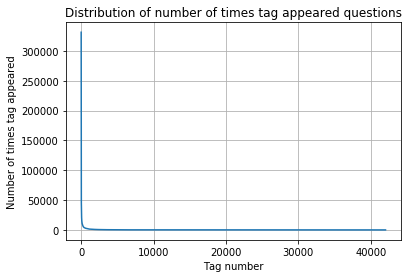

In [22]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

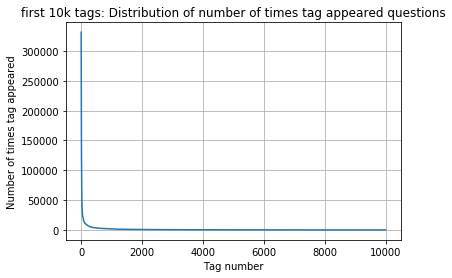

In [23]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
# print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

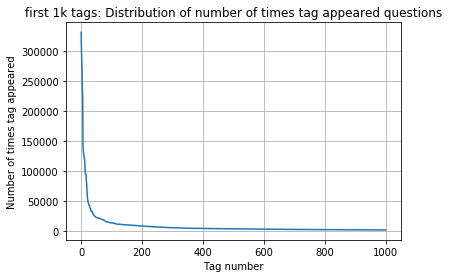

In [24]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
# print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

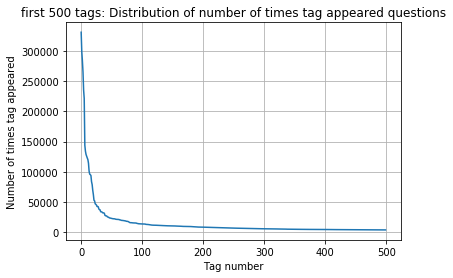

In [25]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
# print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

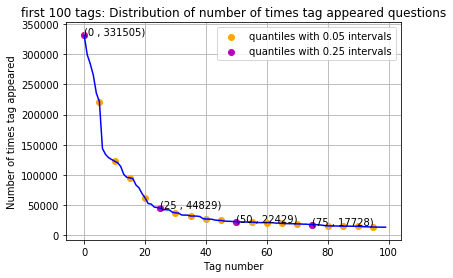

In [21]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
# print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [34]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

<h3> 3.2.4 Tags Per Question </h3>

In [37]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206314 datapoints.
[3, 4, 2, 2, 3]


In [38]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899440


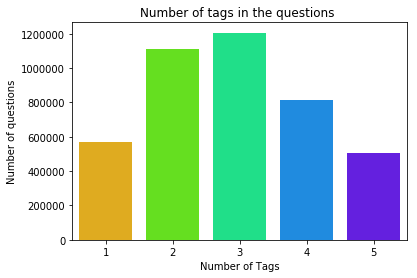

In [28]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

<h3>3.2.5 Most Frequent Tags </h3>

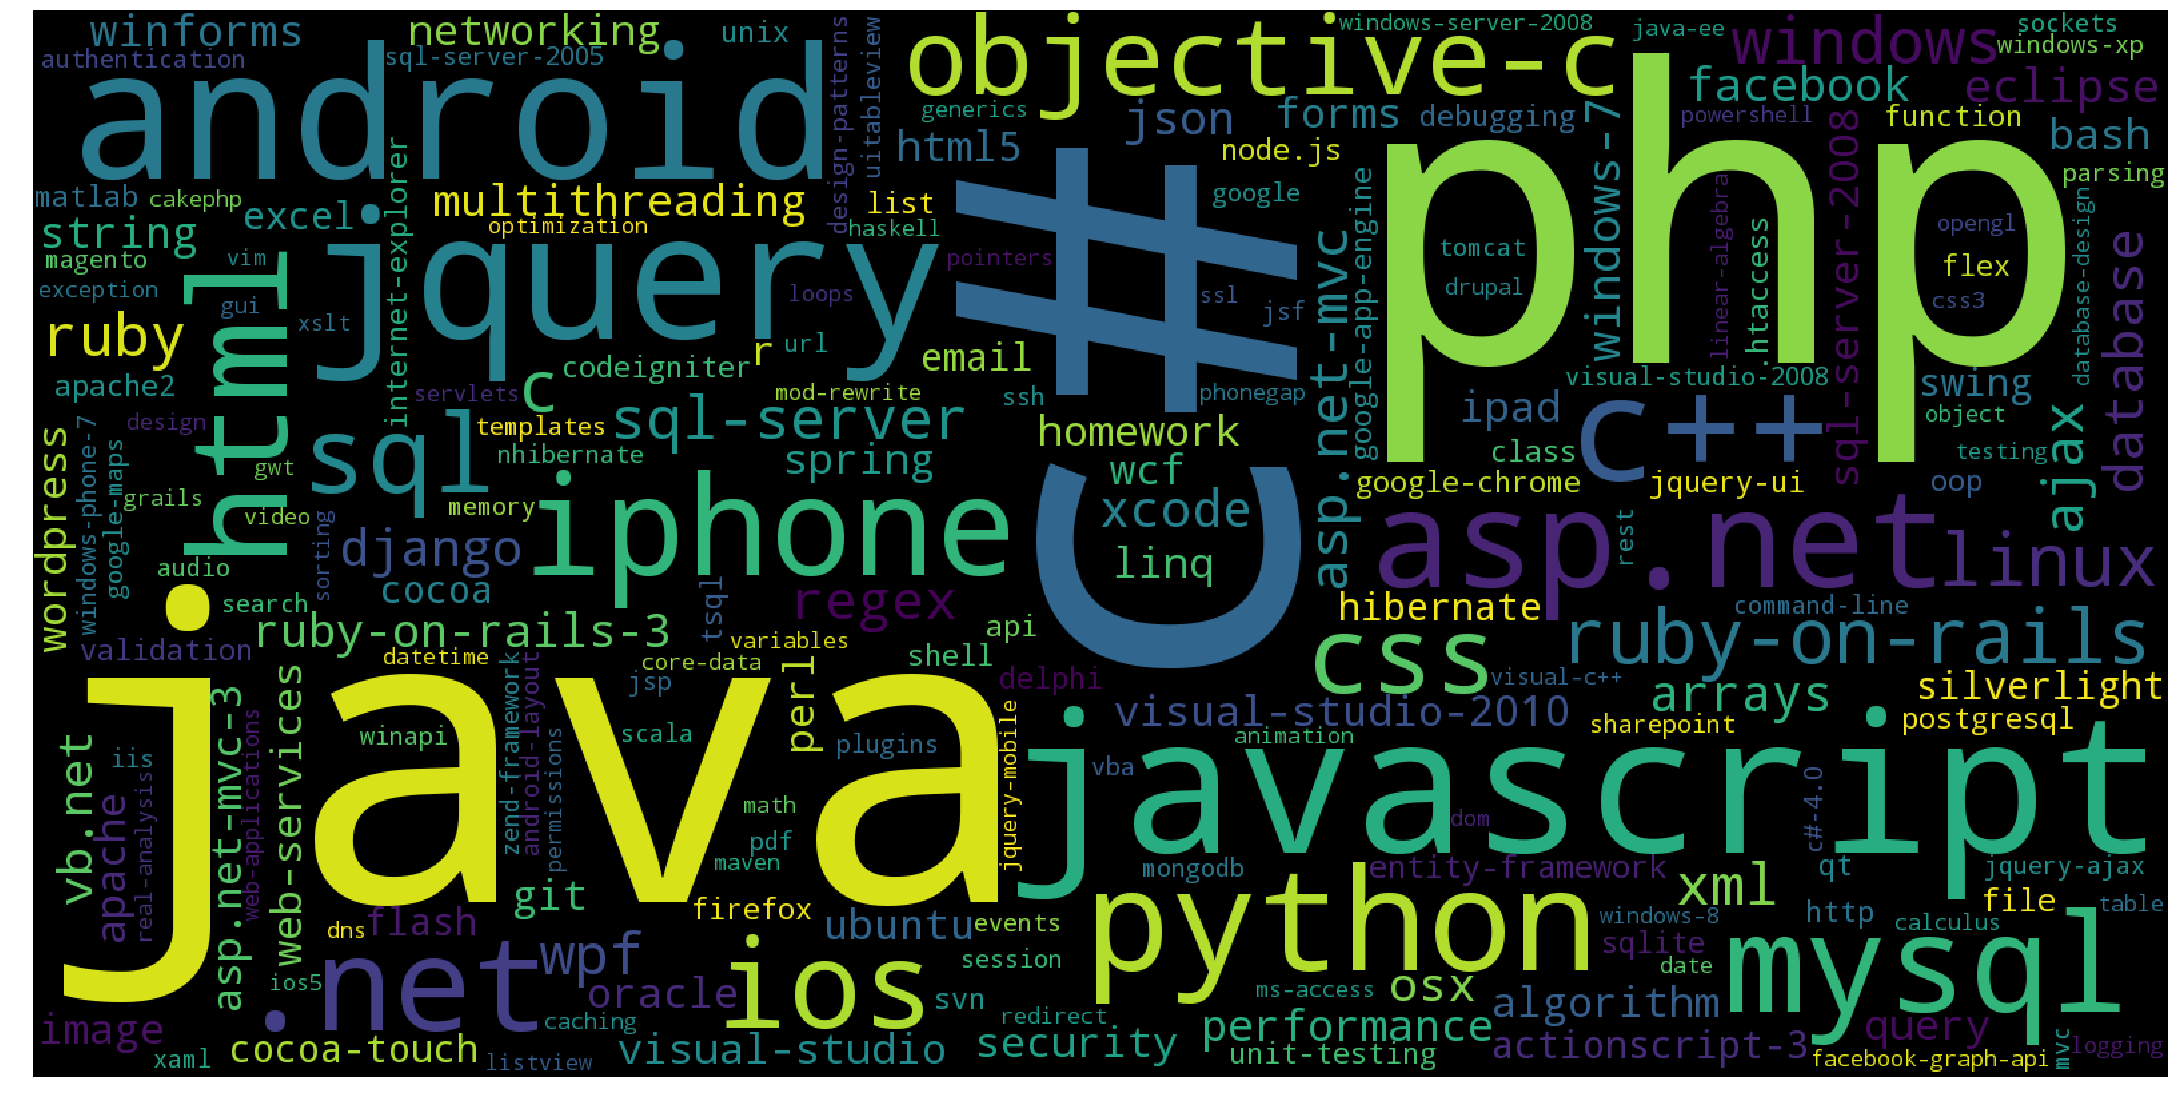

Time taken to run this cell : 0:00:05.069152


In [74]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

<h3> 3.2.6 The top 20 tags </h3>

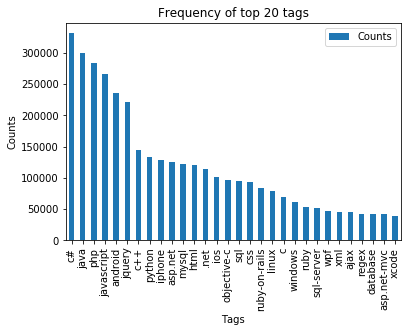

In [29]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

<h3> 3.3 Cleaning and preprocessing of Questions </h3>

<h3> 3.3.1 Preprocessing </h3>

<ol> 
    <li> Sample 100000 data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [4]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [5]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [5]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 200000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:00:55.029846


__ we create a new data base to store the sampled and preprocessed questions __

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/karthikmgcp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/

start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
Avg. length of questions(Title+Body) before processing: 1170
Avg. length of questions(Title+Body) after processing: 326
Percent of questions containing code: 57
Time taken to run this cell : 0:04:44.920212


In [7]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [33]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('jqueri stop anim progress fadeout show mous enter leav quick lt div gt hover show text mous leav text fade howev mous enter lt div gt complet text never show awar prefer use slight perceiv delay give event way upon simpli clear show text current attempt use timeout jsbin http jsbin com upotuw video http www youtub com watch rlrz bequu edit issu need pass paramet function final work code follow http jsbin com upotuw',)
----------------------------------------------------------------------------------------------------
('uniti resolv class base interfac repositori class way regist way want get repositori resolv attempt resolv repositori way give error resolut depend fail type cmcore repositori irepositori cmcore data icmcorelog name none except occur resolv except invalidoperationexcept current type irepositori imyent interfac construct miss type map time except contain resolv irepositori imyent none wrong approach proper way achiev mention function thank l

In [8]:
#Taking 1 Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [10]:
preprocessed_data.to_csv('preprocessed_data_200k.csv', index=False, columns=['question', 'tags'])

In [11]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 199999
number of dimensions : 2


<h1>4. Machine Learning Models </h1>

<h2> 4.1 Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [48]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'].values.astype('U'))

__ We will sample the number of tags instead considering all of them (due to limitation of computing power) __

In [49]:
len((multilabel_y.sum(axis=0).tolist())[0])

18560

In [54]:
multilabel_y.sum(axis=1)

matrix([[2],
        [1],
        [3],
        ...,
        [3],
        [2],
        [3]])

In [18]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [56]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

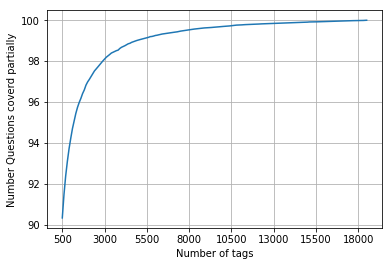

with  5500 tags we are covering  99.143 % of questions


In [57]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [58]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 857 out of  99999


In [59]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 18560
number of tags taken : 5500 ( 29.63362068965517 %)


__ We consider top 15% tags which covers  99% of the questions __

<h2>4.2 Split the data into test and train (80:20) </h2>

In [60]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [61]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (79999, 5500)
Number of data points in test data : (20000, 5500)


In [62]:
y_train

<79999x5500 sparse matrix of type '<class 'numpy.int64'>'
	with 214000 stored elements in Compressed Sparse Row format>

<h2>4.3 Featurizing data </h2>

In [63]:
x_train.shape

(79999, 2)

In [64]:
x_test.shape

(20000, 2)

In [65]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=4, max_features=20000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:02:05.461099


In [66]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (79999, 20000) Y : (79999, 5500)
Dimensions of test data X: (20000, 20000) Y: (20000, 5500)


<h2> 4.4 Applying Logistic Regression with OneVsRest Classifier </h2>

In [72]:
# this will be taking so much time try not to run it, download the lr_with_equal_weight.pkl file and use to predict
# This takes about 6-7 hours to run.
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


accuracy : 0.0801
macro f1 score : 0.08279845423094068
micro f1 scoore : 0.3751105066303979
hamming loss : 0.0004176818181818182
Precision recall report :
               precision    recall  f1-score   support

           0       0.61      0.26      0.36      1567
           1       0.78      0.46      0.58      1452
           2       0.83      0.55      0.66      1371
           3       0.72      0.44      0.55      1284
           4       0.94      0.75      0.83      1126
           5       0.89      0.64      0.75      1098
           6       0.69      0.32      0.44       684
           7       0.88      0.63      0.74       612
           8       0.64      0.40      0.49       593
           9       0.52      0.22      0.31       589
          10       0.76      0.44      0.56       554
          11       0.85      0.62      0.71       608
          12       0.50      0.11      0.18       512
          13       0.56      0.31      0.40       459
          14       0.74      0.54

In [0]:
from sklearn.externals import joblib
joblib.dump(classifier, 'lr_with_equal_weight.pkl') 

In [69]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [70]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table

read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


In [71]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (79999, 20000) Y : (79999, 5500)
Dimensions of test data X: (20000, 20000) Y: (20000, 5500)


<h3> 4.5.1 Preprocessing of questions </h3>

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [47]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 424
Percent of questions containing code: 57
Time taken to run this cell : 0:18:13.366950


In [48]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

__ Sample quesitons after preprocessing of data __

In [49]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advance..',)
----------------------------------------------------------------------------------------------------
('java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl 1.1 tomcat webapp tri project work also tri version 1.2 jstl still messag caus solv',)
----------------------------------------------------------------------------------------------------
('java.sql.sqlexcept microsoft odbc driver

__ Saving Preprocessed data to a Database __

In [50]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [ ]:
preprocessed_data.head()

In [56]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500000
number of dimensions : 2


__ Converting string Tags to multilable output variables __ 

In [51]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ Selecting 500 Tags __

In [52]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

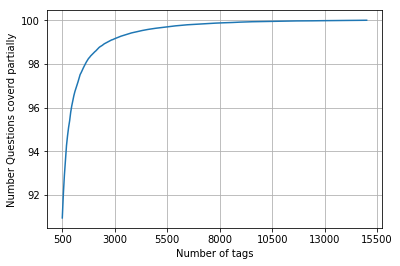

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [95]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [53]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


In [54]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [68]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 5500)
Number of data points in test data : (100000, 5500)


<h3> 4.5.2 Featurizing data with TfIdf vectorizer </h3>

In [55]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False)
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:21.968149


In [56]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 11502) Y : (400000, 500)
Dimensions of test data X: (100000, 11502) Y: (100000, 500)


<h3> 4.5.3 Applying Logistic Regression with OneVsRest Classifier </h3>

In [63]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=2)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23963
Hamming loss  0.00276568
Micro-average quality numbers
Precision: 0.7166, Recall: 0.3381, F1-measure: 0.4594
Macro-average quality numbers
Precision: 0.5499, Recall: 0.2668, F1-measure: 0.3424
              precision    recall  f1-score   support

           0       0.95      0.68      0.79      5519
           1       0.68      0.28      0.40      8190
           2       0.81      0.39      0.53      6529
           3       0.82      0.45      0.58      3231
           4       0.80      0.43      0.56      6430
           5       0.81      0.34      0.48      2879
           6       0.87      0.52      0.65      5086
           7       0.87      0.56      0.68      4533
           8       0.60      0.12      0.21      3000
           9       0.81      0.56      0.66      2765
          10       0.58      0.19      0.29      3051
          11       0.69      0.35      0.46      3009
          12       0.63      0.26      0.37      2630
          13       0.73      0.

In [0]:
joblib.dump(classifier, 'lr_with_more_title_weight.pkl') 

['lr_with_more_title_weight.pkl']

In [73]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.082
Hamming loss  0.0004173090909090909
Micro-average quality numbers
Precision: 0.6749, Recall: 0.2720, F1-measure: 0.3878
Macro-average quality numbers
Precision: 0.1801, Recall: 0.0915, F1-measure: 0.1131
              precision    recall  f1-score   support

           0       0.62      0.24      0.35      1567
           1       0.78      0.46      0.57      1452
           2       0.83      0.55      0.66      1371
           3       0.73      0.44      0.55      1284
           4       0.94      0.74      0.83      1126
           5       0.89      0.65      0.75      1098
           6       0.68      0.31      0.43       684
           7       0.88      0.63      0.74       612
           8       0.62      0.39      0.48       593
           9       0.51      0.22      0.31       589
          10       0.77      0.44      0.56       554
          11       0.84      0.62      0.71       608
          12       0.48      0.10      0.16       512
          13       0.5

### Taking 200K reviews to avoid memory error that happens when we use n_gram_range = (1,4)

In [4]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [5]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [5]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 200000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:00:55.029846


In [15]:
conn_w.close()
conn_r.close()

__ we create a new data base to store the sampled and preprocessed questions __

In [ ]:
import nltk
nltk.download('punkt')

In [43]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/

start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

Avg. length of questions(Title+Body) before processing: 1171
Avg. length of questions(Title+Body) after processing: 327
Percent of questions containing code: 57
Time taken to run this cell : 0:02:25.131012


In [11]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [33]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('jqueri stop anim progress fadeout show mous enter leav quick lt div gt hover show text mous leav text fade howev mous enter lt div gt complet text never show awar prefer use slight perceiv delay give event way upon simpli clear show text current attempt use timeout jsbin http jsbin com upotuw video http www youtub com watch rlrz bequu edit issu need pass paramet function final work code follow http jsbin com upotuw',)
----------------------------------------------------------------------------------------------------
('uniti resolv class base interfac repositori class way regist way want get repositori resolv attempt resolv repositori way give error resolut depend fail type cmcore repositori irepositori cmcore data icmcorelog name none except occur resolv except invalidoperationexcept current type irepositori imyent interfac construct miss type map time except contain resolv irepositori imyent none wrong approach proper way achiev mention function thank l

In [45]:
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [8]:
data = pd.read_csv('preprocessed_data_200k.csv')

### EDA 

In [9]:
data.head()

,question,tags
0,extra file user user profil use follow add pho...,custom-field users
1,dump data mysql databas postgresql databas don...,ruby-on-rails postgresql mysqldump
2,languag make easier understand secur code prin...,security secure-coding
3,callback function jqueri html follow code ajax...,javascript jquery ajax json
4,turn set url regex pattern option pattern ques...,regex


In [10]:
data.shape

(199999, 2)

In [12]:
questions = data['question']

In [17]:
lengths = []
for i in questions:
    words = i.split()
    lengths.append(len(words))

In [42]:
from scipy import stats

Text(0, 0.5, 'no label')

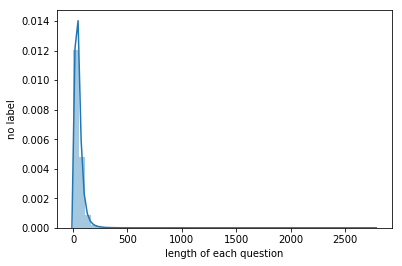

In [82]:
sns.distplot(lengths,)
plt.xlabel('length of each question')
plt.ylabel('no label')

In [36]:
from math import log
loglens = []
for i in lengths:
    loglens.append(log(i))

In [37]:
len(loglens)

199999

### We will plot the log of the lengths

Text(0, 0.5, 'no label')

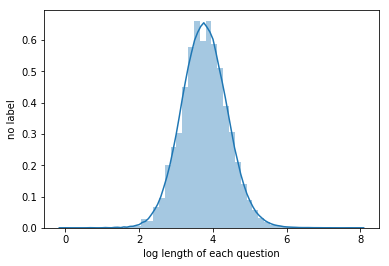

In [81]:
sns.distplot(loglens)
plt.xlabel('log length of each question')
plt.ylabel('no label')

### Therefore we understand we are dealing with log normal distribution.

Text(0, 0.5, 'no of words')

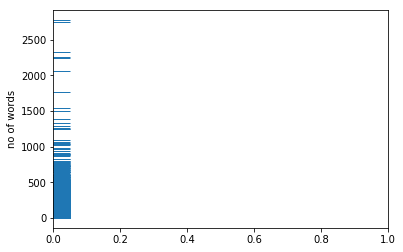

In [83]:
sns.rugplot(lengths, axis=('y'))
plt.ylabel('no of words')

### We get a better understanding that lengths lie between 0 and 750 roughly

In [49]:
tags = data['tags']

In [50]:
len(tags)

199999

In [52]:
tag_length = []
for i in tags:
    words = i.split()
    tag_length.append(len(words))

In [53]:
len(tag_length)

199999

Text(0, 0.5, 'no of questions')

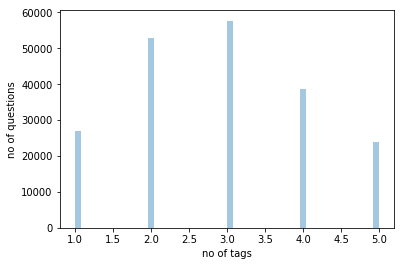

In [84]:
sns.distplot(tag_length, kde=False)
plt.xlabel('no of tags')
plt.ylabel('no of questions')

### most frequent tags

In [69]:
from collections import Counter

In [73]:
frequency = (Counter(data['tags']))

In [75]:
frequencies = []
for k,v in frequency.items():
    frequencies.append(v)

In [77]:
from wordcloud import WordCloud

In [78]:
tup = dict(frequency.items())
wordcloud = WordCloud( background_color='white', width=1600, height=800,).generate_from_frequencies(tup)

(-0.5, 1599.5, 799.5, -0.5)

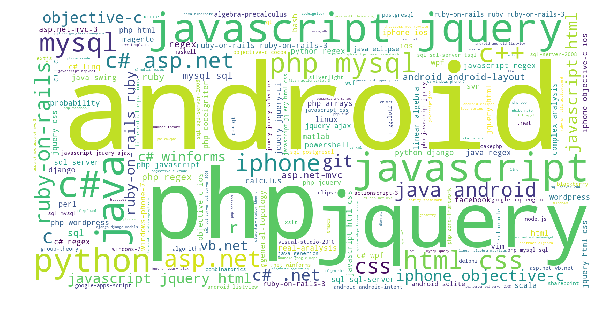

In [79]:
fig = plt.figure(figsize=(10,20))
plt.imshow(wordcloud)
plt.axis('off')

In [89]:
#Saving this dictionary to csv files.
if not os.path.isfile('200k_counts.csv'):
    with open('200k_counts.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in tup.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("200k_counts.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,java mysql netbeans jtable swig,1
1,java oop singleton classloader,1
2,iphone ios cocoa-touch audio,1
3,graphics image-processing imagemagick graphics...,1
4,.net visual-c++ c++-cli hashset visual-c++-2010,1


In [90]:
tag_df_sorted = tag_df.sort_values(by = 'Counts', ascending=False)

In [91]:
tag_df_sorted.head()

,Tags,Counts
98721,android,1687
66418,php,1052
49950,jquery,953
113040,javascript jquery,902
36923,javascript,862


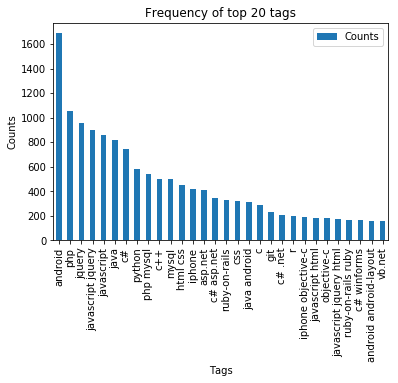

In [92]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

### We are the getting appropriate readings as witnessed!!

### Vectorizing the data

In [16]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(data['tags'])

In [19]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

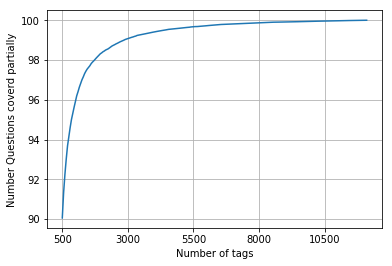

with  5500 tags we are covering  99.074 % of questions
with  500 tags we are covering  90.059 % of questions


In [20]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

### For 500 tags

In [21]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 19882 out of  199999


In [22]:
total_size=data.shape[0]
train_size=int(0.80*total_size)

x_train=data.head(train_size)
x_test=data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [23]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (159999, 500)
Number of data points in test data : (40000, 500)


In [125]:
x_train.head()

,question,tags
0,close dialog mvc en dialog box ckeditor insid ...,asp.net-mvc-3 dialog
1,make error page appear mvc applic current get ...,asp.net-mvc
2,one result show sql request loop reason show l...,php sql while-loops
3,paus thread java consid follow code true somef...,java multithreading
4,monitor xp machin window machin xp machin rout...,windows-7 networking


In [97]:
x_test.shape

(20000, 3)

In [101]:
y_train.shape

(79999, 5500)

In [99]:
y_test.shape

(20000, 5500)

<h3> 4.5.2 Featurizing data with Count vectorizer </h3>

In [24]:
start = datetime.now()
vectorizer = CountVectorizer(max_features=50000,ngram_range=(1,4),tokenizer = lambda x: x.split())
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:04:10.552818


In [25]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (159999, 50000) Y : (159999, 500)
Dimensions of test data X: (40000, 50000) Y: (40000, 500)


In [27]:
from sklearn.model_selection import GridSearchCV

In [ ]:
start = datetime.now()
params = {'estimator__alpha':[0.0001, 0.001, 0.1, 1, 3, 5]}
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'), n_jobs=1)
clf = GridSearchCV(classifier, param_grid=params)
clf.fit(x_train_multilabel, y_train)
predictions = clf.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
Accuracy : 0.1731
Hamming loss  0.0033348
Micro-average quality numbers
Precision: 0.5756, Recall: 0.2940, F1-measure: 0.3892
Macro-average quality numbers
Precision: 0.3594, Recall: 0.1755, F1-measure: 0.2164

In [136]:
clf.best_estimator_

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=1)

### applying learned parameters

In [ ]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l1'), n_jobs=1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
Accuracy : 0.1868
Hamming loss  0.003173
Micro-average quality numbers
Precision: 0.6313, Recall: 0.2882, F1-measure: 0.3957
Macro-average quality numbers
Precision: 0.3660, Recall: 0.1698, F1-measure: 0.2143

### Linear svm

In [ ]:
start = datetime.now()
params = {'estimator__alpha':[0.0001, 0.001, 0.1, 1, 5, 10]}
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1'), n_jobs=1)
clf = GridSearchCV(classifier, param_grid=params)
clf.fit(x_train_multilabel, y_train)
predictions = clf.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
Accuracy : 0.165
Hamming loss  0.00348932
Micro-average quality numbers
Precision: 0.4714, Recall: 0.3502, F1-measure: 0.4019
Macro-average quality numbers
Precision: 0.2818, Recall: 0.2376, F1-measure: 0.2383

### Applying learned params

In [112]:
clf.best_estimator_

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=1)

In [ ]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.001, penalty='l1'), n_jobs=1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
Accuracy : 0.18795
Hamming loss  0.00316135
Micro-average quality numbers
Precision: 0.6381, Recall: 0.2844, F1-measure: 0.3934
Macro-average quality numbers
Precision: 0.2693, Recall: 0.1774, F1-measure: 0.1977

### For 2000 tags

In [31]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(2000)
print("number of questions that are not covered :", questions_explained_fn(2000),"out of ", total_qs)

number of questions that are not covered : 5987 out of  199999


In [32]:
total_size=data.shape[0]
train_size=int(0.80*total_size)

x_train=data.head(train_size)
x_test=data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [33]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (159999, 2000)
Number of data points in test data : (40000, 2000)


In [34]:
x_train.head()

,question,tags
0,extra file user user profil use follow add pho...,custom-field users
1,dump data mysql databas postgresql databas don...,ruby-on-rails postgresql mysqldump
2,languag make easier understand secur code prin...,security secure-coding
3,callback function jqueri html follow code ajax...,javascript jquery ajax json
4,turn set url regex pattern option pattern ques...,regex


In [35]:
x_test.shape

(40000, 2)

In [36]:
y_train.shape

(159999, 2000)

In [37]:
y_test.shape

(40000, 2000)

<h3> 4.5.2 Featurizing data with Count vectorizer </h3>

In [38]:
start = datetime.now()
vectorizer = CountVectorizer(max_features=60000,ngram_range=(1,4),tokenizer = lambda x: x.split())
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:04:19.944767


In [39]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (159999, 60000) Y : (159999, 2000)
Dimensions of test data X: (40000, 60000) Y: (40000, 2000)


In [27]:
from sklearn.model_selection import GridSearchCV

In [ ]:
start = datetime.now()
params = {'estimator__alpha':[0.0001, 0.001, 0.1, 1]}
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'), n_jobs=1)
clf = GridSearchCV(classifier, param_grid=params)
clf.fit(x_train_multilabel, y_train)
predictions = clf.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
Accuracy : 0.085325
Hamming loss  0.0010858
Micro-average quality numbers
Precision: 0.5956, Recall: 0.2211, F1-measure: 0.3225
Macro-average quality numbers
Precision: 0.1216, Recall: 0.0537, F1-measure: 0.0667

In [41]:
clf.best_estimator_

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=1)

### applying learned parameters

In [ ]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l1'), n_jobs=1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
Accuracy : 0.0885
Hamming loss  0.001084725
Micro-average quality numbers
Precision: 0.5928, Recall: 0.2296, F1-measure: 0.3310
Macro-average quality numbers
Precision: 0.1229, Recall: 0.0526, F1-measure: 0.0666

### Linear svm

In [ ]:
start = datetime.now()
params = {'estimator__alpha':[0.0001, 0.001, 0.1, 1, 5, 10]}
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1'), n_jobs=1)
clf = GridSearchCV(classifier, param_grid=params)
clf.fit(x_train_multilabel, y_train)
predictions = clf.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
Accuracy : 0.165
Hamming loss  0.00348932
Micro-average quality numbers
Precision: 0.4714, Recall: 0.3502, F1-measure: 0.4019
Macro-average quality numbers
Precision: 0.2818, Recall: 0.2376, F1-measure: 0.2383

### Applying learned params

In [112]:
clf.best_estimator_

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=1)

In [ ]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.001, penalty='l1'), n_jobs=1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
Accuracy : 0.09235
Hamming loss  0.001080775
Micro-average quality numbers
Precision: 0.5972, Recall: 0.2312, F1-measure: 0.3333
Macro-average quality numbers
Precision: 0.0971, Recall: 0.0612, F1-measure: 0.0684

## Conclusion

In [45]:
from prettytable import PrettyTable

In [59]:
x = PrettyTable()

In [60]:
x.field_names = ['classification algorithm', 'no.of tags used', 'accuracy','f1 score']

In [65]:
print(x)

+--------------------------+-----------------+----------+----------+
| classification algorithm | no.of tags used | accuracy | f1 score |
+--------------------------+-----------------+----------+----------+
|          logreg          |       500       |  18.68   |  39.57   |
|        linear svm        |       500       |  18.79   |  39.34   |
|        linear svm        |       2000      |   9.23   |  33.33   |
|          logreg          |       2000      |   8.85   |   33.1   |
+--------------------------+-----------------+----------+----------+
